In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('lemmatized_without_stopwords.txt') as f:
    reviewsWithoutStopWords = f.read().splitlines()

reviewsWithoutStopWords[0]

"['jan', 'friendly', 'welcome', 'host', 'apartment', 'great', 'area', 'sooo', 'amaze', 'lot', 'nice', 'cafe', 'shop', 'enjoy', 'time', 'lot']"

In [4]:
reviewsWithoutStopWords = [review.replace('\'', '').strip('][').split(', ')
                           for review in reviewsWithoutStopWords]

reviewsWithoutStopWords[0]

['jan',
 'friendly',
 'welcome',
 'host',
 'apartment',
 'great',
 'area',
 'sooo',
 'amaze',
 'lot',
 'nice',
 'cafe',
 'shop',
 'enjoy',
 'time',
 'lot']

## Bigrams generation

In [5]:
from gensim.models.phrases import Phrases, Phraser

phrasesWithoutStopWords = Phrases(reviewsWithoutStopWords,
                                  min_count=3,
                                  progress_per=50000)

bigramWithoutStopWords = Phraser(phrasesWithoutStopWords)

bigramReviewsWithoutStopWords = bigramWithoutStopWords[reviewsWithoutStopWords]

bigramReviewsWithoutStopWords[0]

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


['jan',
 'friendly',
 'welcome',
 'host',
 'apartment',
 'great',
 'area',
 'sooo',
 'amaze',
 'lot',
 'nice',
 'cafe',
 'shop',
 'enjoy',
 'time',
 'lot']

In [6]:
from collections import defaultdict

dictWordFreq = defaultdict(int)
for review in bigramReviewsWithoutStopWords:
    for i in review:
        dictWordFreq[i] += 1

len(dictWordFreq)

64487

In [7]:
# Eventually, show an example of item in word_freq

In [8]:
sorted(dictWordFreq, key=dictWordFreq.get, reverse=True)[:10]

['great',
 'apartment',
 'stay',
 'place',
 'berlin',
 'nice',
 'location',
 'host',
 'clean',
 'good']

## Word2Vec model

In [9]:
from gensim.models import Word2Vec

w2vModelWithoutStopWords = Word2Vec(min_count=20,
                             window=4,
                             vector_size=300,
                             sample=6e-5,
                             alpha=0.03,
                             min_alpha=0.0007,
                             negative=20,
                             workers=4)

In [10]:
from time import time

t = time()

w2vModelWithoutStopWords.build_vocab(bigramReviewsWithoutStopWords, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.14 mins


In [11]:
t = time()

w2vModelWithoutStopWords.train(bigramReviewsWithoutStopWords,
                               total_examples=w2vModelWithoutStopWords.corpus_count,
                               epochs=30,
                               report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 5.71 mins


In [55]:
# w2vModelWithoutStopWords.save("word2vec_no_stopwords.model")

## Exploring the model

In [13]:
w2vModelWithoutStopWords.wv.most_similar(positive=["apartment"])

[('flat', 0.6878382563591003),
 ('spacious', 0.4964258074760437),
 ('modern', 0.48108017444610596),
 ('studio', 0.4650469124317169),
 ('clean', 0.4501889944076538),
 ('comfortably_furnish', 0.38306912779808044),
 ('building', 0.3798222839832306),
 ('bright', 0.377280056476593),
 ('modern_furnishing', 0.37452903389930725),
 ('beautifully_appoint', 0.37319716811180115)]

## Clustering model

In [14]:
from sklearn.cluster import KMeans
import numpy as np

kmeansModel2Clusters = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeansModel2Clusters.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

In [15]:
w2vModelWithoutStopWords.wv.similar_by_vector(kmeansModel2Clusters.cluster_centers_[0],
                                              topn=10,
                                              restrict_vocab=None)

[('due_lack', 0.6634340882301331),
 ('wire', 0.660079300403595),
 ('useless', 0.636574387550354),
 ('unacceptable', 0.6353410482406616),
 ('rug', 0.6306374073028564),
 ('take_trash', 0.6300591826438904),
 ('filthy', 0.6290209293365479),
 ('leak', 0.6218292117118835),
 ('trap', 0.6210276484489441),
 ('smelly', 0.6185833811759949)]

In [16]:
negativeClusterIndex = 0

In [18]:
dfWords2ClustersWithoutStopWords = pd.DataFrame(
    w2vModelWithoutStopWords.wv.key_to_index.keys())

dfWords2ClustersWithoutStopWords.columns = ['words']

dfWords2ClustersWithoutStopWords['vectors'] = \
    dfWords2ClustersWithoutStopWords['words'].apply(
        lambda x: w2vModelWithoutStopWords.wv[f'{x}'])

dfWords2ClustersWithoutStopWords['cluster'] = \
    dfWords2ClustersWithoutStopWords['vectors'].apply(
        lambda x: kmeansModel2Clusters.predict([np.array(x)]))

dfWords2ClustersWithoutStopWords['cluster'] = \
    dfWords2ClustersWithoutStopWords['cluster'].apply(
        lambda x: x[0])

dfWords2ClustersWithoutStopWords.head()

,words,vectors,cluster
0,great,"[0.021736015, -0.09696648, -0.20334733, 0.3184...",1
1,apartment,"[0.09413033, -0.20562932, -0.09986646, -0.0815...",1
2,stay,"[-0.04194155, 0.27263644, -0.30879694, -0.4886...",1
3,place,"[0.1171688, -0.45740342, -0.18468466, 0.219762...",1
4,berlin,"[-0.062057998, 0.043246496, -0.19278, -0.67646...",1


In [19]:
dfWords2ClustersWithoutStopWords['cluster_value'] = [
    -1 if i==negativeClusterIndex else 1
    for i in dfWords2ClustersWithoutStopWords['cluster']]

dfWords2ClustersWithoutStopWords['closeness_score'] = \
    dfWords2ClustersWithoutStopWords.apply(
        lambda x: 1/(kmeansModel2Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords2ClustersWithoutStopWords['sentiment_coeff'] = \
    dfWords2ClustersWithoutStopWords['closeness_score'] * \
    dfWords2ClustersWithoutStopWords['cluster_value']

dfWords2ClustersWithoutStopWords[
    dfWords2ClustersWithoutStopWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
11,room,"[-0.1289804, -0.47577977, 0.45509025, 0.071285...",0,-1,0.135719,-0.135719
18,comfortable,"[-0.105109595, -0.28582796, 0.23227535, -0.098...",0,-1,0.139571,-0.139571
40,like,"[0.2838839, -0.5819455, 0.27681106, -0.0084737...",0,-1,0.132852,-0.132852
45,one,"[-0.7768008, -0.64739054, 0.637206, -0.629718,...",0,-1,0.162380,-0.162380
46,bed,"[-0.37433314, -0.19291034, 0.44292012, -0.3003...",0,-1,0.107758,-0.107758


## TF-IDF

In [20]:
dfCleanedReviewsWithoutStopWords = pd.DataFrame(
    [' '.join(review) for review in reviewsWithoutStopWords],
    columns=['comments'])

dfCleanedReviewsWithoutStopWords.head()

,comments
0,jan friendly welcome host apartment great area...
1,really nice area food park transport perfect
2,nice stay berlin thanks jan premium situate ap...
3,great location close mauerpark kastanienallee ...
4,apartment well locate close everything superma...


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfWithoutStopWords = TfidfVectorizer(norm=None)
transformed = tfidfWithoutStopWords.fit_transform(
    dfCleanedReviewsWithoutStopWords['comments'].tolist())
features = pd.Series(tfidfWithoutStopWords.get_feature_names())

In [22]:
def create_tfidf_dictionary(x, transformed_file, features_file):
    """
    create dictionary for each input sentence x, where each word has assigned its tfidf score

    inspired  by function from this wonderful article:
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features_file.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features_file):
    """
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    dictionary = create_tfidf_dictionary(x, transformed_file, features_file)
    try:
        res = list(map(lambda y:dictionary[f'{y}'], x['comments'].split()))
    except KeyError:
        res = [0 for i in x['comments'].split()]
    return res

In [23]:
tfidfScoresWithoutStopWords = dfCleanedReviewsWithoutStopWords.apply(
    lambda x: replace_tfidf_words(x, transformed, features), axis=1)

pandas.core.series.Series

In [24]:
dictSentiment2ClustersWithoutStopWords = dict(zip(
    dfWords2ClustersWithoutStopWords['words'].values,
    dfWords2ClustersWithoutStopWords['sentiment_coeff'].values))

In [25]:
def replace_sentiment_words(word, sentiment_dict):
    """
    replacing each word with its associated sentiment score from sentiment dict
    """
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [26]:
closenessScores2ClustersWithoutStopWords = \
    dfCleanedReviewsWithoutStopWords['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment2ClustersWithoutStopWords),
            x.split())))

In [27]:
dfSentiment2ClustersTfidfReviewsWithoutStopWords = \
    pd.DataFrame([closenessScores2ClustersWithoutStopWords,
                  tfidfScoresWithoutStopWords,
                  dfCleanedReviewsWithoutStopWords['comments']]).T

dfSentiment2ClustersTfidfReviewsWithoutStopWords.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment2ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] = \
    dfSentiment2ClustersTfidfReviewsWithoutStopWords.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'] =\
    (dfSentiment2ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.08274272026931886, 0.14438650901133268, 0.1...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,8.102213,1
1,"[0.21196840433660452, 0.17771365086007282, 0.1...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,2.926502,1
2,"[0.17771365086007282, 0.17679454909616302, 0.1...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,15.925815,1
3,"[0.20011867647250559, 0.16337263418936798, 0.1...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.887016,1
4,"[0.18721176816409277, 0.1347721306573096, 0.11...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,5.763220,1


In [28]:
dfNegativeSentiment = dfSentiment2ClustersTfidfReviewsWithoutStopWords[
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

print('Top-5 negative reviews:')
dfNegativeSentiment['review'].head().tolist()

Top-5 negative reviews:


['big flat heart neuk lln min station nice flatmate amazing room day everything fine flat mate nice reccomend every website hide airbnb sure like thanks benjamin sonia luca website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb',
 'one word mouse get apartment find mice run living room bedroom hysteria contact host benjamin respond right away tell us sunday know could nothing could check problem really mice problem tell family small child berlin high season would go tell would contact airbnb change apartment look hotel back forth say would borrow cat friend seem like g

In [56]:
# dfSentiment2ClustersTfidfReviewsWithoutStopWords.to_csv(
#     'sentiment_dataset_2_clusters_no_stopwords.csv',
#     sep=',', index=False, header=True)

inertia_ 1019374.8914507161
inertia_ 979036.4512069453
inertia_ 945731.9965046742
inertia_ 928825.8544302889
inertia_ 916296.311814165
inertia_ 903468.412742547
inertia_ 893577.2260768567
inertia_ 886675.7141103031
inertia_ 879206.5099118422
inertia_ 872744.2123647004


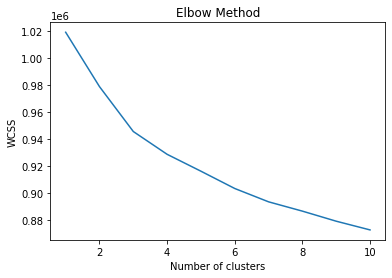

In [30]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))
    # inertia_ is sum of squared distance of samples to its closest cluster centers.
    wcss.append(kmeans.inertia_)
    print("inertia_", kmeans.inertia_)
    # print("wcss", within_css(kmeans))

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [31]:
from sklearn.metrics import silhouette_score

def kmeans_silhouette(X,range_clusters):
    for i, k in range_clusters :

        # Run the Kmeans algorithm
        km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)

        km.fit(X)
        labels = km.predict(X)

        print("For n_clusters =", k,
                  "The computed average silhouette_score is :",
              silhouette_score(X, labels, metric='euclidean'))

In [32]:
rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
kmeans_silhouette(w2vModelWithoutStopWords.wv.vectors.astype('double'), rangeClusters)

For n_clusters = 2 The computed average silhouette_score is : 0.06882298045419695
For n_clusters = 3 The computed average silhouette_score is : 0.05184578923038232
For n_clusters = 4 The computed average silhouette_score is : 0.0489808665742103
For n_clusters = 5 The computed average silhouette_score is : 0.004672535626036191
For n_clusters = 6 The computed average silhouette_score is : -0.0008970731786193938
For n_clusters = 7 The computed average silhouette_score is : -0.007605956063358059
For n_clusters = 8 The computed average silhouette_score is : -0.04694576278840496
For n_clusters = 9 The computed average silhouette_score is : -0.04297953670725326
For n_clusters = 10 The computed average silhouette_score is : -0.04051978810825676


## 3-clusters

In [33]:
kmeansModel3Clusters = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50)
kmeansModel3Clusters.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=3, n_init=50, random_state=42)

In [34]:
w2vModelWithoutStopWords.wv.similar_by_vector(
    kmeansModel3Clusters.cluster_centers_[2], topn=10, restrict_vocab=None)

[('wire', 0.6604833006858826),
 ('due_lack', 0.6506068110466003),
 ('rug', 0.6456260085105896),
 ('useless', 0.6366190314292908),
 ('filthy', 0.6263508796691895),
 ('smelly', 0.6249639987945557),
 ('bathroom', 0.6226907968521118),
 ('leak', 0.6207293272018433),
 ('unacceptable', 0.6182073950767517),
 ('tape', 0.6162527203559875)]

In [35]:
negativeClusterIndex = 2
positiveClusterIndex = 0

In [36]:
dfWords3ClustersWithoutStopWords = pd.DataFrame(
    w2vModelWithoutStopWords.wv.key_to_index.keys())

dfWords3ClustersWithoutStopWords.columns = ['words']

dfWords3ClustersWithoutStopWords['vectors'] = \
    dfWords3ClustersWithoutStopWords['words'].apply(
        lambda x: w2vModelWithoutStopWords.wv[f'{x}'])

dfWords3ClustersWithoutStopWords['cluster'] = \
    dfWords3ClustersWithoutStopWords['vectors'].apply(
        lambda x: kmeansModel3Clusters.predict([np.array(x)]))

dfWords3ClustersWithoutStopWords.cluster = \
    dfWords3ClustersWithoutStopWords['cluster'].apply(
        lambda x: x[0])

dfWords3ClustersWithoutStopWords.head()

,words,vectors,cluster
0,great,"[0.021736015, -0.09696648, -0.20334733, 0.3184...",1
1,apartment,"[0.09413033, -0.20562932, -0.09986646, -0.0815...",1
2,stay,"[-0.04194155, 0.27263644, -0.30879694, -0.4886...",1
3,place,"[0.1171688, -0.45740342, -0.18468466, 0.219762...",1
4,berlin,"[-0.062057998, 0.043246496, -0.19278, -0.67646...",0


In [37]:
dfWords3ClustersWithoutStopWords['cluster_value'] = \
    [-1 if i==negativeClusterIndex
     else 1 if i==positiveClusterIndex else 0
     for i in dfWords3ClustersWithoutStopWords['cluster']]

dfWords3ClustersWithoutStopWords['closeness_score'] = \
    dfWords3ClustersWithoutStopWords.apply(
        lambda x: 1/(kmeansModel3Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords3ClustersWithoutStopWords['sentiment_coeff'] = \
    dfWords3ClustersWithoutStopWords['closeness_score'] * \
    dfWords3ClustersWithoutStopWords['cluster_value']

dfWords3ClustersWithoutStopWords[
    dfWords3ClustersWithoutStopWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
11,room,"[-0.1289804, -0.47577977, 0.45509025, 0.071285...",2,-1,0.137974,-0.137974
18,comfortable,"[-0.105109595, -0.28582796, 0.23227535, -0.098...",2,-1,0.142628,-0.142628
40,like,"[0.2838839, -0.5819455, 0.27681106, -0.0084737...",2,-1,0.133966,-0.133966
45,one,"[-0.7768008, -0.64739054, 0.637206, -0.629718,...",2,-1,0.161954,-0.161954
46,bed,"[-0.37433314, -0.19291034, 0.44292012, -0.3003...",2,-1,0.109352,-0.109352


In [38]:
dictSentiment3ClustersWithoutStopWords = dict(zip(
    dfWords3ClustersWithoutStopWords['words'].values,
    dfWords3ClustersWithoutStopWords['sentiment_coeff'].values))

In [39]:
closenessScores3ClustersWithoutStopWords = \
    dfCleanedReviewsWithoutStopWords['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment3ClustersWithoutStopWords),
            x.split())))

In [40]:
dfSentiment3ClustersTfidfReviewsWithoutStopWords = pd.DataFrame(
    [closenessScores3ClustersWithoutStopWords,
     tfidfScoresWithoutStopWords,
     dfCleanedReviewsWithoutStopWords['comments']]).T

dfSentiment3ClustersTfidfReviewsWithoutStopWords.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment3ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] = \
    dfSentiment3ClustersTfidfReviewsWithoutStopWords.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'] = \
    (dfSentiment3ClustersTfidfReviewsWithoutStopWords['sentiment_rate']>0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1530401787107...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,3.171116,1
1,"[0.0, 0.0, 0.1530401787107593, 0.0962295034379...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,1.725799,1
2,"[0.0, 0.0, 0.1417771922395551, 0.0, 0.0, -0.14...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,4.913388,1
3,"[0.0, 0.1948514168094835, 0.14606870725559232,...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,3.140077,1
4,"[0.0, 0.12948971833364556, 0.14316824211234594...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,2.336270,1


In [57]:
# dfSentiment3ClustersTfidfReviewsWithoutStopWords.to_csv(
#     'sentiment_dataset_3_clusters_no_stopwords.csv',
#     sep=',', index=False, header=True)

In [43]:
dfNegativeSentiment = dfSentiment3ClustersTfidfReviewsWithoutStopWords[
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

dfNegativeSentiment['review'].head().tolist()

['one word mouse get apartment find mice run living room bedroom hysteria contact host benjamin respond right away tell us sunday know could nothing could check problem really mice problem tell family small child berlin high season would go tell would contact airbnb change apartment look hotel back forth say would borrow cat friend seem like good idea terrible problem lend pet stranger felt like short story bring two cat apartment dealt immediate emergency mouse run around tell cat ingenious idea okay untenable situation handle mouse cat one cat actually actively go mouse cat well behave pleasant mean need care get fee incessant nudging feed vacation benjamin home rental apartment business fair mouse feces remain unabated benjamin evidently come apartment without knowledge except alert us bring exterminator exterminator say apparently entire building contaminate mouse set poison traps host exterminator discuss mouse entry point observed location mouse droppings throughout apartment dis

## TextBlob

In [44]:
from textblob import TextBlob

In [45]:
textblobSentimentWithoutStopWords = dfCleanedReviewsWithoutStopWords['comments'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

textblobSentimentWithoutStopWords.head()

0    0.595000
1    0.800000
2    0.487500
3    0.587500
4    0.229762
Name: comments, dtype: float64

In [49]:
dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] = \
    textblobSentimentWithoutStopWords

dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_prediction'] = \
    (dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.08274272026931886, 0.14438650901133268, 0.1...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,8.102213,1,0.595000,1
1,"[0.21196840433660452, 0.17771365086007282, 0.1...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,2.926502,1,0.800000,1
2,"[0.17771365086007282, 0.17679454909616302, 0.1...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,15.925815,1,0.487500,1
3,"[0.20011867647250559, 0.16337263418936798, 0.1...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.887016,1,0.587500,1
4,"[0.18721176816409277, 0.1347721306573096, 0.11...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,5.763220,1,0.229762,1


In [50]:
dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] = \
    textblobSentimentWithoutStopWords

dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_prediction'] = \
    (dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1530401787107...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,3.171116,1,0.595000,1
1,"[0.0, 0.0, 0.1530401787107593, 0.0962295034379...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,1.725799,1,0.800000,1
2,"[0.0, 0.0, 0.1417771922395551, 0.0, 0.0, -0.14...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,4.913388,1,0.487500,1
3,"[0.0, 0.1948514168094835, 0.14606870725559232,...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,3.140077,1,0.587500,1
4,"[0.0, 0.12948971833364556, 0.14316824211234594...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,2.336270,1,0.229762,1


## Sentiment Analysis Evaluation

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def compute_test_scores(predictions, labels):

    df_conf_matrix = pd.DataFrame(confusion_matrix(predictions, labels))

    print(df_conf_matrix)

    test_scores = accuracy_score(predictions, labels), \
                  precision_score(predictions, labels), \
                  recall_score(predictions, labels), \
                  f1_score(predictions, labels)

    return test_scores

In [53]:
testScores2ClustersSentiment = compute_test_scores(
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'],
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_prediction'])

dfTestScores2ClustersSentiment = pd.DataFrame([testScores2ClustersSentiment])
dfTestScores2ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores2ClustersSentiment = dfTestScores2ClustersSentiment.T
dfTestScores2ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 2 clusters and no stopwords: ')
dfTestScores2ClustersSentiment

      0       1
0  1425   13517
1  3100  240725
Scores for sentiment analysis with 2 clusters and no stopwords: 


,scores
accuracy,0.935784
precision,0.946834
recall,0.987286
f1,0.966637


In [54]:
testScores3ClustersSentiment = compute_test_scores(
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'],
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_prediction'])

dfTestScores3ClustersSentiment = pd.DataFrame([testScores3ClustersSentiment])
dfTestScores3ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores3ClustersSentiment = dfTestScores3ClustersSentiment.T
dfTestScores3ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 3 clusters and no stopwords: ')
dfTestScores3ClustersSentiment


      0       1
0  3263  108395
1  1262  145847
Scores for sentiment analysis with 3 clusters and no stopwords: 


,scores
accuracy,0.576233
precision,0.573654
recall,0.991421
f1,0.726780
